### Preliminaries

In [ ]:
#Import the needed libraries

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path

import functools
import glob
import gzip
import multiprocessing
import os
import shutil
import tempfile
from typing import List, Optional, Tuple


#import gdal
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import s2geometry as s2
import shapely
#import tensorflow as tf
import tqdm.notebook

In [ ]:
#Get working directory
os.getcwd()

#Change directory if needed
#os.chdir('C:\\Users\ASUS\Documents\Spatial Learning')

### Shapefiles and their engineering

In [ ]:
#Import shapefiles with all of the US including islands and others using geopandas
#Convert shapefiles to EPSG 3857

# original dataset for counties and cities (might come in handy)
us_main = gpd.read_file(r'C:/Users/ASUS/Documents/Spatial Learning/tl_2019_us_county/tl_2019_us_county.shp')
us_main = us_main.to_crs(3857)
uscity = gpd.read_file(r'C:/Users/ASUS/Documents/Spatial Learning/500Cities_City_11082016/CityBoundaries.shp')
uscity = uscity.to_crs(3857)


#State Shapefile boundaries
us = gpd.read_file(r'C:/Users/ASUS/Documents/Spatial Learning/DS4A/T51/t51/us_states.shp')
us = us.to_crs(3857)

#US boundary shapefile - to clip the data
usBound = gpd.read_file(r'C:/Users/ASUS/Documents/Spatial Learning/DS4A/T51/t51/us_dis.shp')
usBound = usBound.to_crs(3857)

In [ ]:
#Check Coordinate reference system and convert to projected if not matching
# Set the list of shapefiles that you want to process
shapefile_list = [us_main, us, usBound, uscity]

# Iterate through the list of shapefiles
for i, df in enumerate(shapefile_list):
    # Get the CRS of the GeoDataFrame as a string
    crs = df.crs.to_string()

    # Print the name of the GeoDataFrame and its CRS
    print(f'Shapefile {i}: {crs}')

    # Check if the CRS is EPSG:3857
    if crs != 3857:
        # If the CRS is not EPSG:3857, convert it
        df = df.to_crs(epsg=3857)

print(f'Shapefile {i}: {crs} Done')

Shapefile 0: EPSG:3857
Shapefile 1: EPSG:3857
Shapefile 2: EPSG:3857
Shapefile 3: EPSG:3857
Shapefile 3: EPSG:3857 Done


In [ ]:
#clip the data to show only continental US
us_county = gpd.clip(us_main, usBound) # - clip US Counties
uscityBound = gpd.clip(uscity, usBound)# - clip us cities

C:\Users\ASUS\anaconda3\envs\geoai\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

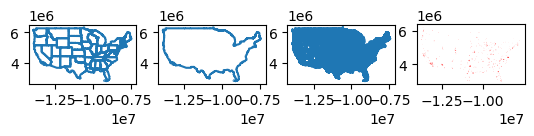

In [ ]:
#plot data to visualize
fig, axes = plt.subplots(nrows = 1, ncols = 4)
#plt.figure(figsize=(25,25))

us.boundary.plot(ax=axes[0])
usBound.boundary.plot(ax=axes[1])
us_county.boundary.plot(ax=axes[2])
uscityBound.plot(color='red', ax=axes[3])

### Feature engineering to clean dataset and format

In [ ]:
#US County Dataset

us_county.columns = us_county.columns.str.lower() #convert all column names to lower case

#drop irrelevant column and rename retained
us_county = us_county.drop(['countyns','lsad', 'classfp', 'mtfcc', 'csafp', 'cbsafp', 'metdivfp', 'funcstat',
      'aland', 'awater', 'intptlat', 'intptlon'], axis=1)
us_county = us_county.rename(columns={'name': 'county_name', 'namelsad': 'countyname', 'countyfp': 'countyfips', 'statefp': 'statefips'})
us_county.sort_values(by='county_name')


us_county['countyfips'] = us_county['countyfips'].astype(int)

In [ ]:
us_county.head(5)

,statefips,countyfips,geoid,county_name,countyname,geometry
2772,48,43,48043,Brewster,Brewster County,"POLYGON ((-11502123.107 3579104.603, -11501882..."
1240,48,377,48377,Presidio,Presidio County,"POLYGON ((-11638023.725 3467240.127, -11638024..."
2140,48,443,48443,Terrell,Terrell County,"POLYGON ((-11375546.514 3484137.122, -11375550..."
2512,48,105,48105,Crockett,Crockett County,"POLYGON ((-11304282.883 3540645.340, -11304322..."
1335,48,371,48371,Pecos,Pecos County,"POLYGON ((-11494007.877 3648115.499, -11493985..."


In [ ]:
#US Cities with Average temperature

uscitiestemp = pd.read_csv('C:\\Users\\ASUS\\Documents\\Spatial Learning\\DS4A\\cities_county_temp.csv')
uscitiestemp = uscitiestemp.drop(columns='Unnamed: 0')
uscitiestemp.head(2)

,city,state_id,state_name,county_name,lat,lng,Year 2010,AverageTemperature
0,Chandler,AZ,Arizona,Maricopa,33.0,112.0,2010-01-01,53.2724
1,Chandler,AZ,Arizona,Maricopa,33.0,112.0,2010-02-01,54.8510


### Clean the Water Data

In [ ]:
#Water Dataset for 2015

#Import data
water_2015 = pd.read_csv('C:/Users/ASUS/Documents/Spatial Learning/DS4A/Jose/Using/usco2015v2.0.csv', error_bad_lines=False, sep = ",")

#select relevant columns, rename column names, convert column names to lower cases and remove extras in county name
water_us = water_2015[['STATE', 'STATEFIPS', 'COUNTY', 'COUNTYFIPS', 'FIPS', 'YEAR', 'TP-TotPop', 'PS-TOPop', 'TO-Wtotl', 'PS-Wtotl', 'IR-WFrTo', 'IR-IrTot',]]
water_us = water_us.rename(columns = {'STATE': 'state_id', 'COUNTY': 'county_name', 'TP-TotPop':'population', 'PS-TOPop':'population_served', 'TO-Wtotl':'total_withdrawals', 'PS-Wtotl':'public_supply', 'IR-WFrTo':'Totalirrig_withdraw', 'IR-IrTot':'Totalirrigated_acres'})

water_us.columns = water_us.columns.str.lower()
water_us['county_name'] = water_us['county_name'].str.replace(' County', '')

water_us.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_30072\881267194.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  water_2015 = pd.read_csv('C:/Users/ASUS/Documents/Spatial Learning/DS4A/Jose/Using/usco2015v2.0.csv', error_bad_lines=False, sep = ",")


,state_id,statefips,county_name,countyfips,fips,year,population,population_served,total_withdrawals,public_supply,totalirrig_withdraw,totalirrigated_acres
0,AL,1,Autauga,1,1001,2015,55.347,48.998,56.41,3.64,3.52,2.26
1,AL,1,Baldwin,3,1003,2015,203.709,174.907,84.70,23.67,58.28,20.66
2,AL,1,Barbour,5,1005,2015,26.489,24.587,9.02,3.23,2.96,4.53
3,AL,1,Bibb,7,1007,2015,22.583,20.947,5.87,5.18,0.19,0.16
4,AL,1,Blount,9,1009,2015,57.673,44.815,60.07,56.86,1.08,0.94


In [ ]:
data.to_csv('state_data.csv')

# Join Water data to cities and temperature

In [ ]:
# Merge the GeoDataFrames using the specified columns
merged_df = pd.merge(us_county, uscitiestemp, on='county_name', how='inner')
t51 = pd.merge(merged_df, water_us, on='county_name')

# Print the resulting GeoDataFrame
print(t51)

      statefips_x  countyfips_x  geoid county_name         countyname  \
0              04            23  04023  Santa Cruz  Santa Cruz County   
1              04            23  04023  Santa Cruz  Santa Cruz County   
2              04            23  04023  Santa Cruz  Santa Cruz County   
3              04            23  04023  Santa Cruz  Santa Cruz County   
4              04            23  04023  Santa Cruz  Santa Cruz County   
...           ...           ...    ...         ...                ...   
45811          41            51  41051   Multnomah   Multnomah County   
45812          41            51  41051   Multnomah   Multnomah County   
45813          41            51  41051   Multnomah   Multnomah County   
45814          41            51  41051   Multnomah   Multnomah County   
45815          41            51  41051   Multnomah   Multnomah County   

                                                geometry      city state_id_x  \
0      POLYGON ((-12349588.282 3727492.256

In [ ]:
t51.head(2)

,statefips_x,countyfips_x,geoid,county_name,countyname,geometry,city,state_id_x,state_name,lat,...,statefips_y,countyfips_y,fips,year,population,population_served,total_withdrawals,public_supply,totalirrig_withdraw,totalirrigated_acres
0,04,23,04023,Santa Cruz,Santa Cruz County,"POLYGON ((-12349588.282 3727492.256, -12349542...",Nogales,AZ,Arizona,31.0,...,4,23,4023,2015,46.461,41.501,13.22,5.17,6.97,2.32
1,04,23,04023,Santa Cruz,Santa Cruz County,"POLYGON ((-12349588.282 3727492.256, -12349542...",Nogales,AZ,Arizona,31.0,...,6,87,6087,2015,274.146,247.932,58.65,18.45,31.34,22.71


In [ ]:
#Drop repetitive columns
t51 = t51.drop(columns=['statefips_x', 'countyfips_x', 'geoid', 'countyname', 'state_id_y', 'statefips_y', 'countyfips_y', 'fips'], axis=1)
t51.head(2)

,county_name,geometry,city,state_id_x,state_name,lat,lng,Year 2010,AverageTemperature,year,population,population_served,total_withdrawals,public_supply,totalirrig_withdraw,totalirrigated_acres
0,Santa Cruz,"POLYGON ((-12349588.282 3727492.256, -12349542...",Nogales,AZ,Arizona,31.0,111.0,2010-01-01,49.3754,2015,46.461,41.501,13.22,5.17,6.97,2.32
1,Santa Cruz,"POLYGON ((-12349588.282 3727492.256, -12349542...",Nogales,AZ,Arizona,31.0,111.0,2010-01-01,49.3754,2015,274.146,247.932,58.65,18.45,31.34,22.71


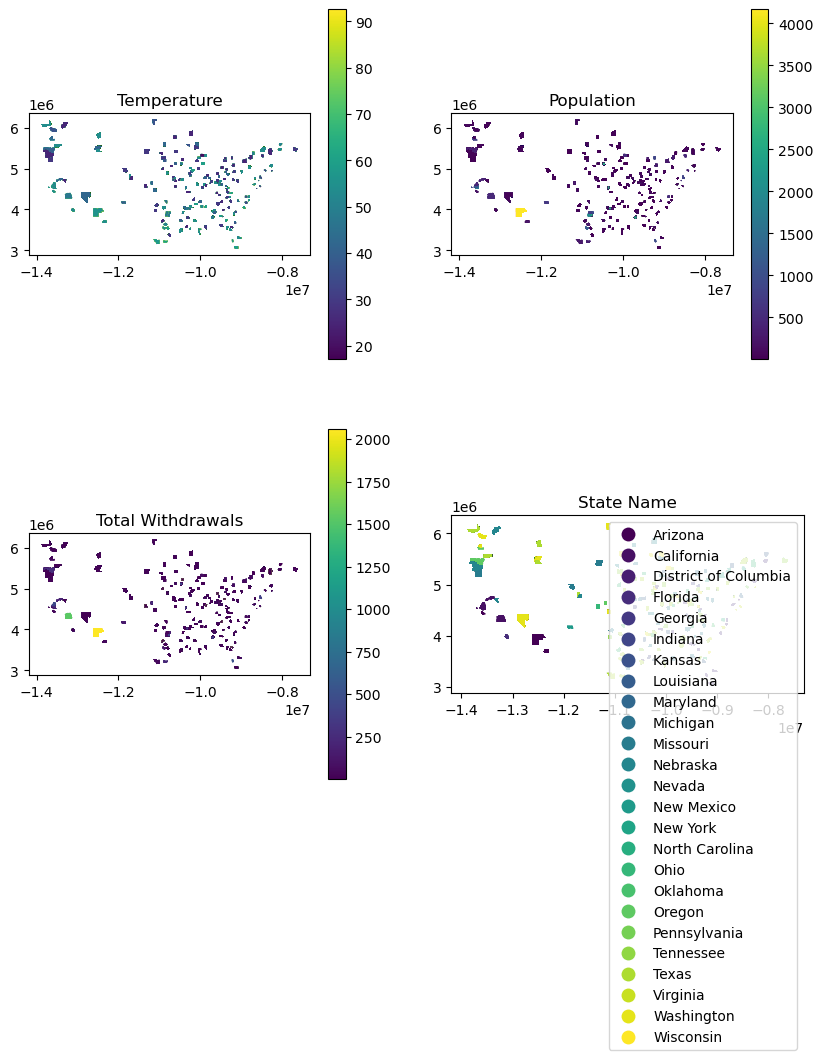

In [ ]:
#plot the map on temperature, population and total withdrawals

# Create a figure with two rows and two columns
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Set the titles for each subplot
titles = ['Temperature', 'Population', 'Total Withdrawals', 'State Name']

# Iterate through the subplots
for ax, col, title in zip(axs.flat, ['AverageTemperature', 'population', 'total_withdrawals', 'state_name'], titles):
    # Create a map for the current subplot
    t51.plot(column=col, ax=ax, legend=True, cmap='viridis')
    ax.set_title(title)

# Show the plot
plt.show()


<AxesSubplot: >

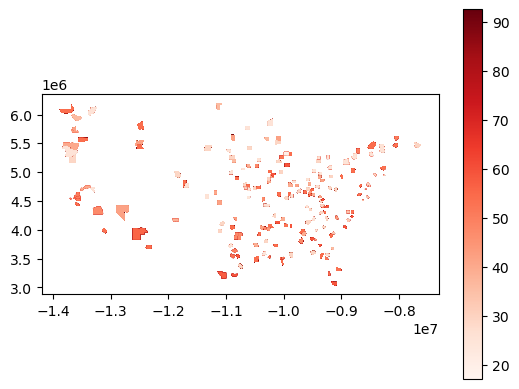

In [ ]:
t51.plot(column='AverageTemperature', cmap='Reds', legend=True)

In [ ]:
data = pd.merge(water_us, uscitiestemp, on='state_id', how='inner')
#data.groupby('city').agg()

In [ ]:
data.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
#Import the temperature dataset
temp = pd.read_csv('C:\\Users\\ASUS\\Documents\\Spatial Learning\\DS4A\\glt_us_cities_2010.csv')
temp = temp.set_index('Year')
temp = temp.reset_index()

#Use the describe() function to get the mean of the data and then transpose the dataset
cities_temp = temp.describe()
cities_temp = cities_temp.transpose()

#drop irrelevant columns, rename to tempperature, set index to city and reset index
cities_temp = cities_temp.drop(columns=['count', 'std', 'min', '25%', '50%', '75%', 'max'])
cities_temp = cities_temp.rename(columns={'mean': 'temperature'})
cities_temp.index.name = 'city'
cities_temp.reset_index()

In [ ]:
us_data = gpd.GeoDataFrame(water_us.merge(us_county, on='county', how='inner'))

In [ ]:
data2 = pd.merge(data, cities_temp, on='state_id', how='outer')
data

In [ ]:
us_states = us_data.dissolve(by='state')

In [ ]:
us_states.set_index('statefips_x')
us_states.head(2)

In [ ]:
#us2 = gpd.overlay(us_states, us_county, how= 'intersection')
#us2.plot(edgecol)

In [ ]:
us_states.plot(column='population', cmap='Reds')

fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()

plt.title('US Map')
#for x, y, label in zip(us_states.geometry.centroid.x, us_states.geometry.centroid.y, us_states['state']):
   # plt.annotate(label, xy= (x, y), xytext=(3,3), textcoords='offset points')
    
plt.show()

# ## Later use

In [ ]:
state_dict = {'AL': 'Alabama', 'AZ':'Arizona', 'AR':'Arkansas', 'AS':'AmericanSamoa', 'CA':'California', 'CO':'Colorado', 'CT':'Connecticut', 'DE':'Delaware', 'DC':'DistrictofColumbia', 'FL':'Florida', 
'GA':'Georgia', 'GU':'Guam', 'HI':'Hawaii', 'ID':'Idaho', 'IL':'Illinois', 'IN':'Indiana', 'IA':'Iowa', 'KS':'Kansas', 'KY':'Kentucky', 'LA':'Louisiana', 'ME':'Maine',  
'MD':'Maryland', 'MA':'Massachusetts', 'MI':'Michigan',  'MN':'Minnesota',  'MS':'Mississippi', 'MO':'Missouri', 'MT':'Montana', 'NE':'Nebraska', 'NV':'Nevada',  
'NH':'NewHampshire', 'NJ':'NewJersey', 'NM':'NewMexico', 'NY':'NewYork', 'NC':'NorthCarolina', 'ND':'NorthDakota', 'MP':'NorthernMarianaIslands', 'OH':'Ohio','OK':'Oklahoma', 
'OR':'Oregon',  'PA':'Pennsylvania', 'PR':'PuertoRico', 'RI':'RhodeIsland', 'SC':'SouthCarolina', 'SD':'SouthDakota', 'TN':'Tennessee', 'TX':'Texas', 'TT':'TrustTerritories', 
'UT':'Utah', 'VT':'Vermont', 'VA':'Virginia', 'VI':'VirginIslands', 'WA':'Washington', 'WV':'WestVirginia', 'WI':'Wisconsin', 'WY':'Wyoming'}

In [ ]:
'''
us_data = us_data.replace({'state': state_dict})
us_county['county'].isin(water_us['county']).value_counts()
us_county.county.sort_values().unique().tolist()
'''

In [ ]:
us_data.to_crs(crs=4326)

In [ ]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
ax.annotate(s=us_data['state'], xy=us_data.geometry.centroid, xytext=us_data['state'], ha='center', fontsize=14)

#us_data.apply(lambda x: ax.annotate(s=x.state, xy=x.geometry.centroid.coords[0], 
                                 #   text=(us_data['state']), ha='center', fontsize=14),axis=1);
us_data.boundary.plot(ax=ax, color='Black', linewidth=.4)
us_data.plot(ax=ax, cmap='Pastel2', figsize=(12, 12))
ax.text(-0.05, 0.5, 'https://jcutrer.com', transform=ax.transAxes,
        fontsize=20, color='gray', alpha=0.5,
        ha='center', va='center', rotation='90')

In [ ]:
us_data.plot()

fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()

plt.title('US Map')
for x, y, label in zip(us_data.geometry.centroid.x,us_data.geometry.centroid.y, us_data['state']):
    plt.annotate(label, xy= (x, y), xytext=(3,3), textcoords='offset points')
    
plt.show()

In [ ]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
  
  
fig, ax = plt.subplots(1, figsize =(16, 8),
                       facecolor ='lightblue')
  
us_data.plot(ax = ax, color ='black')
us_data.plot(ax = ax, column ='tp-totpop', cmap ='Reds',
           edgecolors ='grey')
  
# axis for the color bar
div = make_axes_locatable(ax)
cax = div.append_axes("right", size ="3 %", pad = 0.05)
  
# color bar
vmax = us_data.tp-totpop.max()
mappable = plt.cm.ScalarMappable(cmap ='Reds',
                                 norm = plt.Normalize(vmin = 0, vmax = vmax))
cbar = fig.colorbar(mappable, cax)
  
ax.axis('off')
plt.show()

In [ ]:
import dtale

In [ ]:
d = dtale.show(water_us)
d

In [ ]:
state_data2 = pd.read_csv('C:/Users/ASUS/Documents/Spatial Learning/state2.csv', header=2)

In [ ]:
state_data2 = state_data2.rename(columns={'State': 'state'})
#state_data.to_csv('state2.csv')

In [ ]:
#state_data2 = state_data2[['StateLab', 'state']]
state_data2 = state_data2.drop(state_data2.iloc[:, 0:1], axis =1)
state_data2.dtypes

In [ ]:
state_data2.values

In [ ]:
def replacerlist[]:
    if text in column = replacee:
        column.replace(replacerlist)
    else:
        print('no list')

In [ ]:
statedict = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'American Samoa': 'AS', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL',
'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands': 'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 
'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Trust Territories': 'TT', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Virgin Islands': 'VI', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 
'Wyoming': 'WY'}